# This script is used to automatically generate custom datasets to support object detection as well as 3D and 2D pose estimation, including camera data.

**WARNING :** In this version, restrict the **Colony size** to a **maxmimum of 1 indivudal**!

Ensure, that your **GPU** has sufficient **memory** for the chosen resolution! 

The script **excludes empty samples** (*no detections present*) automatically and provide an additional **occlusion vector**, indicating whether a key point is visible (1) or occluded (0).

In [1]:
import cv2
import pathlib

import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

In [2]:
# define location of dataset and return all files
dataset_location = "C:/Users/Legos/Documents/PhD/FARTS/generated_data/Output_3D_pose_640_px_single_sungaya"
target_dir = "C:/Users/Legos/Documents/PhD/FARTS/3D_Pose_single_test"
all_files = [f for f in listdir(dataset_location) if isfile(join(dataset_location, f))]

# next, sort files into images, depth maps, segmentation maps, data, and colony info
dataset_img = []
dataset_depth = []
dataset_seg = []
dataset_data = []
dataset_colony = dataset_location + "/ColonieInfo.csv"

for file in all_files:
    loc = dataset_location + "/" + file
    if file[-7:-4] == "Img":
        dataset_img.append(loc)
    elif file[-7:-4] == "Seg":
        dataset_seg.append(loc)
    elif file[-8:-4] == "Depth":
        dataset_depth.append(loc)
    elif file[-8:-4] == "Data":
        dataset_data.append(loc)
        
print("Found",len(all_files),"files...")

# next sort the colony info into its IDs to determine the colony size and individual scales
# one entry for each successive ID is read
from csv import reader

colony = {'seed': 0,
            'ID': [],
         'scale': []}

with open(dataset_colony, 'r') as colony_file:
        print("reading", file)
        # pass the file object to reader() to get the reader object
        csv_reader = reader(colony_file)
        # iterate over each row in the csv using reader object
        for r, row in enumerate(csv_reader):
            if r == 0:
                colony['seed'] = row[0].split("=")[-1]
            else:
                colony['ID'].append(row[0].split("=")[-1])
                colony['scale'].append(row[1].split("=")[-1])

print("Loaded colony file with seed",colony['seed'],"and",len(colony['ID']),"individual(s).")
if len(colony['ID']) == 1:
    multi_animal = False
    print("Generating single-animal dataset!")
else:
    multi_animal = True
    print("Generating multi-animal dataset!")

Found 201 files...
reading ColonieInfo.csv
Loaded colony file with seed  50 and 1 individual(s).
Generating single-animal dataset!


Now that we have the cleaned colony info, we can start loading the data associated with each frame.
For simplicity, we will produce a list of lists, containing all individuals and their attributes for each frame.

We will therefore access "data" as **[frame] [individual] [attribute]**, where attributes will include [ID,bbox_x_0,bbox_y_0,...]

The data files additionally contain **camera information**, such as **transformation**, **rotation**, and **intrinsics**.

In [3]:
data = []
camera_data = []

# get the types of camera information stored
camera_data_types = []
with open(dataset_data[0], 'r') as read_obj:
    csv_reader = reader(read_obj)
    for row in csv_reader:
        # check if the line contains camera or individual data
        if row[0][:3] == "cam":
            for elem in row:
                camera_data_types.append(elem.split("=")[0])

for file in dataset_data:
    # store all returned coordinates for each individual
    coords = []
    camera_attributes = []    
    # open file in read mode
    with open(file, 'r') as read_obj:
        #print("reading", file)
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        # iterate over each row in the csv using reader object
        for row in csv_reader:
            # check if the line contains camera or individual data
            camera_attributes = []
            if row[0][:3] == "cam":
                for elem in row:
                    try:
                        camera_attributes.append(float(elem.split("=")[-1]))
                    except ValueError:
                        pass
                camera_data.append(camera_attributes)
                
            else:
                individual = [float(row[0].split(".")[0])]
                # row variable is a list that represents a row in csv
                for elem in row:
                    try:
                        individual.append(float(elem.split("=")[-1]))
                    except ValueError:
                        pass
                coords.append(individual)
        
    data.append(coords)

# now let's quickly return if the dataset contains what we were looking for    
print("\nThe dataset has a total of", len(data),"generated frames.\n")

if len(camera_data) != 0:
    print("Found camera data for the following attributes:\n",camera_data_types,"\n")
    print("example camera data of",dataset_data[0].split("/")[-1],":\n",camera_data[0])


The dataset has a total of 50 generated frames.

Found camera data for the following attributes:
 ['camera_Loc_X', 'camera_Loc_Y', 'camera_Loc_Z', 'camera_Rot_X', 'camera_Rot_Y', 'camera_Rot_Z', 'camera_fx', 'camera_fy', 'camera_cx', 'camera_cy'] 

example camera data of 10_Data.csv :
 [522.876038, -557.101868, 403.70459, -144.27153, -83.838959, -20.014778, 3200.0, 3200.0, 320.0, 320.0]


As there may be animals for which we don't use all bones we can return a list of all labels and exclude the respective locations from the pose data. As all animals use the same convention, we can simply read in one example and remove the corresponding indices from all animals.

In [4]:
# first open and read the first line from the first imported data file
labels = []
entries_found = False
entry = 0

while not entries_found:
    with open(dataset_data[entry], 'r') as read_obj:
        print("reading", read_obj.name)
        # pass the file object to reader() to get the reader object
        csv_reader = reader(read_obj)
        row_0 = next(csv_reader)  # gets the first line
        # iterate over each row in the csv using reader object
        if row_0[0][:3] != "cam":
            entries_found = True
            for elem in row_0:
                try:
                    labels.append((elem.split("=")[0].split("Bone.")[-1]))
                except ValueError:
                    pass
        else:
            print("No entries found! Reading next file... \n")
            entry += 1

# show all used labels:
print("\nAll labels:")
print(labels)

reading C:/Users/Legos/Documents/PhD/FARTS/generated_data/Output_3D_pose_640_px_single_sungaya/10_Data.csv
No entries found! Reading next file... 

reading C:/Users/Legos/Documents/PhD/FARTS/generated_data/Output_3D_pose_640_px_single_sungaya/11_Data.csv

All labels:
['0.BoundingBox.BoundMin.X', 'BoundingBox.BoundMin.Y', 'BoundingBox.BoundMax.X', 'BoundingBox.BoundMax.Y', 'b_t.X', 'b_t.Y', 'b_t.X_world', 'b_t.Y_world', 'b_t.Z_world', 'b_a_1.X', 'b_a_1.Y', 'b_a_1.X_world', 'b_a_1.Y_world', 'b_a_1.Z_world', 'b_a_2.X', 'b_a_2.Y', 'b_a_2.X_world', 'b_a_2.Y_world', 'b_a_2.Z_world', 'b_a_3.X', 'b_a_3.Y', 'b_a_3.X_world', 'b_a_3.Y_world', 'b_a_3.Z_world', 'b_a_4.X', 'b_a_4.Y', 'b_a_4.X_world', 'b_a_4.Y_world', 'b_a_4.Z_world', 'b_a_5.X', 'b_a_5.Y', 'b_a_5.X_world', 'b_a_5.Y_world', 'b_a_5.Z_world', 'b_a_5_end.X', 'b_a_5_end.Y', 'b_a_5_end.X_world', 'b_a_5_end.Y_world', 'b_a_5_end.Z_world', 'l_1_co_r.X', 'l_1_co_r.Y', 'l_1_co_r.X_world', 'l_1_co_r.Y_world', 'l_1_co_r.Z_world', 'l_1_tr_r.X', 'l

Now that we have loaded data and colony info we can start plotting bounding boxes, joint locations, and check if the camera attributes have been exported correctly.

In [5]:
# transform between sRGB and linear colour space (optional)

def to_linear(srgb):
    linear = np.float32(srgb) / 255.0
    less = linear <= 0.04045
    linear[less] = linear[less] / 12.92
    linear[~less] = np.power((linear[~less] + 0.055) / 1.055, 2.4)
    return linear * 255.0

    
def from_linear(linear):
    srgb = linear.copy()
    less = linear <= 0.0031308
    srgb[less] = linear[less] * 12.92
    srgb[~less] = 1.055 * np.power(linear[~less], 1.0 / 2.4) - 0.055
    return srgb * 255.0

# and compute the XYZ rotation matrix from roll, pitch, and yaw
def get_rotation_matrix(roll,pitch,yaw,degrees=True):
    # convert to radian
    if degrees:
        roll = np.radians(roll)
        pitch = np.radians(pitch)
        yaw = np.radians(yaw)
    # roll rotation 
    Rx = np.array([[1, 0, 0],
                   [0,np.cos(roll),-np.sin(roll)],
                   [0,np.sin(roll),np.cos(roll)]])
    # pitch rotation
    Ry = np.array([[np.cos(pitch),0,np.sin(pitch)],
                   [0, 1, 0],
                   [-np.sin(pitch),0,np.cos(pitch)]])
    # yaw rotation
    Rz = np.array([[np.cos(yaw),-np.sin(yaw),0],
                   [np.sin(yaw),np.cos(yaw),0],
                   [0, 0, 1]])
    #Rxyz = np.round(np.matmul(np.matmul(Rz,Ry),Rx),3)
    Rxyz = Rz @ Ry @ Rx
    return Rxyz

## Generating 3D pose output files
Now comes the difficult part: getting all this data into the required format.

We're going to want an **.h5** formatted file, essentially one dataframe for the entire dataset with the following entries:

*	  file_name &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 string (relative)
*	  rot_mat	&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 x 3 float
*	  trans_mat	&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 x 1 float
*	  intrinsics_mat &nbsp;&nbsp;&nbsp; 3 x 3 float
*     bounding_box &nbsp;&nbsp;&nbsp; 4 x 1 float
*	  key_points_3D &nbsp;&nbsp;&nbsp;3 x k float (provide name sheet)
*	  key_points_2D &nbsp;&nbsp;&nbsp;2 x k float
*	  visibility &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 x k int (0 occluded or 1 visible)

To provide visibility info, we will check whether the subject is visbile in the respective segmentation map at the given screen X & Y coordinates.

In [6]:
# let's create a big dictionary to store all our dataset info and
# save it all to the desired .csv and .h5 files

out_df = pd.DataFrame(index=range(len(data)),columns=["file_name",
                                                      "cam_rot",
                                                      "cam_trans",
                                                      "cam_intrinsics",
                                                      "bounding_box",
                                                      "key_points_3D",
                                                      "key_points_2D",
                                                      "visibility"])
#	- scorer   #(just one, the only scorer is the generator)
#	- - individuals
#	- - - bodyparts
#	- - - - coords

print("Number of loaded samples:",len(data))
print("Colony size:",len(colony['ID']))
print("body parts:",int((len(labels)-4)/5)," (including image X & Y, as well as world X Y Z coordinates)\n")
print("Resulting in a dataframe of shape:",out_df.shape)

output_file_names = ["" for i in range(len(data))]

Number of loaded samples: 50
Colony size: 1
body parts: 70  (including image X & Y, as well as world X Y Z coordinates)

Resulting in a dataframe of shape: (50, 8)


In [7]:
# create unique colours for each ID
import numpy as np
import time

# alright. Let's take it from the top and fucking multi-thread this.
import threading
import queue
import sys
import os

def fix_bounding_boxes(coords,max_val = [1024,1024]):
    # fix bounding box coordinates so they do not reach beyond the image
    fixed_coords = []
    for c, coord in enumerate(coords):
        if c == 0 or c == 2:
            max_val_temp = max_val[0]
        else:
            max_val_temp = max_val[1]
            
        if coord >= max_val_temp:
            coord = max_val_temp
        elif coord <= 0:
            coord = 0
        
        fixed_coords.append(int(coord))
        
    return fixed_coords

def getThreads():
    """ Returns the number of available threads on a posix/win based system """
    if sys.platform == 'win32':
        return int(os.environ['NUMBER_OF_PROCESSORS'])
    else:
        return int(os.popen('grep -c cores /proc/cpuinfo').read())

class exportThread(threading.Thread):
    def __init__(self, threadID, name, q):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.q = q

    def run(self):
        print("Starting " + self.name)
        process_detections(self.name, self.q)
        print("Exiting " + self.name)
        
def createThreadList(num_threads):
    threadNames = []
    for t in range(num_threads):
        threadNames.append("Thread_" + str(t))

    return threadNames

def process_detections(threadName, q):
    while not exitFlag_export:
        queueLock.acquire()
        if not workQueue_export.empty():
            
            data_input = q.get()
            i = data_input[0]
            img = data_input[1]
            queueLock.release()
            
            display_img = cv2.imread(img)
            display_img_orig = display_img.copy()
            
            img_shape = display_img.shape
            
            img_name = target_dir + "/" + img.split('/')[-1][:-4] + "_synth" + ".png"
            # write the file path to the all_points array
            output_file_names[i] = img_name
            out_df.loc[i]["file_name"] = img_name.split("/")[-1]

            img_info = []
                
            # compute visibility for each individual
            seg_img = cv2.imread(dataset_seg[i])
            seg_img_display = seg_img.copy()
            
            # set the default visibility to zero to exclude emtpy images
            out_df.loc[i]["visibility"] = []

            for im, individual in enumerate(data[i]):
                
                bbox = fix_bounding_boxes(individual[1:5],max_val=display_img.shape)
                out_df.loc[i]["bounding_box"] = bbox
                    
                # FOR SOME REASON OCCASIONALLY THE ID OF THE SEG FILE IS LOWER THAN THE DATA FILE
                # with: ID = red_channel/255 * im
                # red_channel = (ID/im) * 255
                ID_red_val = int((individual[0]/len(colony['ID']))*255)
                
                try:
                    ID_mask = cv2.inRange(seg_img[bbox[1]:bbox[3],bbox[0]:bbox[2]], np.array([0,0, ID_red_val - 2]), np.array([0,0, ID_red_val + 2]))
                    indivual_occupancy = cv2.countNonZero(ID_mask)
                except:
                    indivual_occupancy = 1

                #indivual_occupancy = np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255)]).all(axis = 2)) + np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255 - 1)]).all(axis = 2)) + np.count_nonzero((seg_img == [0, 0, int((individual[0]/len(colony['ID']))*255 + 1)]).all(axis = 2))
                bbox_area = abs((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])) + 1
                bbox_occupancy = indivual_occupancy / bbox_area
                #print("Individual", individual[0], "with bounding box occupancy ",bbox_occupancy)
                
                # write all camera attributes to the output file
                # for details, refer to https://ksimek.github.io/2013/08/13/intrinsic/

                out_df.loc[i]["cam_trans"] = camera_data[i][0:3]
                out_df.loc[i]["cam_rot"] = get_rotation_matrix(roll=camera_data[i][3],
                                                               pitch=camera_data[i][4],
                                                               yaw=camera_data[i][5])
                """
                out_df.loc[i]["cam_intrinsics"] = np.array([[camera_data[i][6],0,camera_data[i][8]],
                                                            [0, camera_data[i][7],camera_data[i][9]],
                                                            [0,0,1]])
                """
                out_df.loc[i]["cam_intrinsics"] = np.array([[320,0,320],
                                                            [0, 320,320],
                                                            [0,0,1]])
                
                
                visbility_img = []
                XY_2D_points = []
                XYZ_3D_points = []
                
                #cv2.putText(display_img, "ID: " + str(int(individual[0])), (bbox[0] + 10,bbox[3] - 10), font, fontScale, fontColor, lineType)
                if bbox_occupancy > visibility_threshold:
                    # let's binarise the image and dilate it to make sure all points that visible are found
                    seg_bin = cv2.inRange(seg_img, np.array([0,0, ID_red_val - 2]), np.array([0,245, ID_red_val + 2]))
                    kernel = np.ones((5,5),np.uint8)
                    seg_bin_dilated = cv2.dilate(seg_bin,kernel,iterations = 1)
                    
                    
                    for point in range(int(len(individual[5:])/5)):
                        if exclude_wings:
                            if labels[3 + point*5][0] == "w":
                                # skip all entries containing wing data
                                continue
                                
                        if individual[point*5 + 5] > img_shape[0] or individual[point*5 + 5] < 0 or individual[point*5 + 6] > img_shape[1] or individual[point*5 + 6] < 0:
                            # exclude all points that lie outside the image
                            visibility_point = 0
                            XY_2D_points.append([0,0])
                            XYZ_3D_points.append([0,0,0])
                        else:
                            # check if the 2D point is occluded in the segmentation image
                            # thanks opencv, of course this has to be indexed as Y,X... thanks, really.
                            if seg_bin_dilated[int(individual[6 + point*5]),int(individual[5 + point*5])] == 255:                   
                                visibility_point = 1
                                XY_2D_points.append(np.array(individual[5 + point*5 : 7 + point*5]).astype(int))
                                XYZ_3D_points.append(np.round(individual[7 + point*5 : 10 + point*5],3))
                                
                                # draw 2D points for visualisation
                                if len(threadList_export) == 1:
                                    seg_img_display = cv2.circle(seg_img_display, (int(individual[5 + point*5]),
                                                                                   int(individual[6 + point*5])), 
                                                                                   radius=0, color=(255, 100, 100), 
                                                                                   thickness=5)
                            else:
                                visibility_point = 0
                                XY_2D_points.append([0,0])
                                XYZ_3D_points.append([0,0,0])
                        
                        visbility_img.append(visibility_point)
                        
                if len(threadList_export) == 1:       
                    cv2.imshow("Segmentation and points", seg_img_display)
                    cv2.imshow("Segmentation binarised and dilated", seg_bin_dilated)
                    cv2.waitKey(0) 

                out_df.loc[i]["visibility"] = visbility_img
            
            # if no entries were found for the respective image, remove it from the output list and don't write out the image
            if len(data[i]) == 0 or len(out_df.loc[i]["visibility"]) == 0:
                remove_empty_entries.append(i)
            else:    
                out_df.loc[i]["key_points_2D"] = XY_2D_points
                out_df.loc[i]["key_points_3D"] = XYZ_3D_points
                cv2.imwrite(img_name, display_img)
            
        else:
            queueLock.release()
            
# setup as many threads as there are (virtual) CPU cores
exitFlag_export = 0
# set the following to 1 (instead of getThreads()) to display segmentation maps and visible key points
threadList_export = createThreadList(getThreads())
print("Using", len(threadList_export), "threads for export...")
queueLock = threading.Lock()

# define paths to all images and set the maximum number of items in the queue equivalent to the number of images
workQueue_export = queue.Queue(len(dataset_img))
threads = []
threadID = 1

np.random.seed(seed=1)

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
lineType = 2

# remove entries that contain no data
remove_empty_entries = []

# set true if generating dataset for animal without wings
exclude_wings = True

# we can additionally plot the points in the data files to check joint locations
plot_joints = True

# remember to refine an export folder when saving out your dataset
generate_dataset = True

# determine the proportion of a bounding box that needs to be filled before considering the visibility as too low
# WARNING: At the moment the ID shown in segmentation maps does not always correspond to the ID in the data file (off by 1)
visibility_threshold = 0.001

timer = time.time()

# Create new threads
for tName in threadList_export:
    thread = exportThread(threadID, tName, workQueue_export)
    thread.start()
    threads.append(thread)
    threadID += 1

# Fill the queue with stacks
queueLock.acquire()
for i,img in enumerate(dataset_img):
    workQueue_export.put([i, img])
queueLock.release()

# Wait for queue to empty
while not workQueue_export.empty():
    pass

# Notify threads it's time to exit
exitFlag_export = 1

# Wait for all threads to complete
for t in threads:
    t.join()
print("Exiting Main export Thread")

# close all windows if they were opened
cv2.destroyAllWindows()

print("Total time elapsed:",time.time()-timer,"seconds")

Using 12 threads for export...
Starting Thread_0
Starting Thread_1
Starting Thread_2
Starting Thread_3
Starting Thread_4Starting Thread_5

Starting Thread_6
Starting Thread_7
Starting Thread_8
Starting Thread_9
Starting Thread_10
Starting Thread_11
Exiting Thread_2
Exiting Thread_7
Exiting Thread_8
Exiting Thread_6
Exiting Thread_1Exiting Thread_9
Exiting Thread_10
Exiting Thread_0

Exiting Thread_11
Exiting Thread_5
Exiting Thread_4
Exiting Thread_3
Exiting Main export Thread
Total time elapsed: 0.7444248199462891 seconds


Now, remove empty entries and dump it all into one **.h5** file.

In [8]:
# remove empty entries when training with a single animal
out_df.drop(out_df.index[remove_empty_entries], inplace=True)
# reset the indices of the updated dataframe
out_df.reset_index(drop=True, inplace=True)
out_df.to_hdf(os.path.join(target_dir, "Data_3D_Pose.hdf5"),"df_with_missing",mode="w")

out_df

C:\Users\Legos\anaconda3\envs\tf-gpu\lib\site-packages\pandas\core\generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['file_name', 'cam_rot', 'cam_trans', 'cam_intrinsics', 'bounding_box',
       'key_points_3D', 'key_points_2D', 'visibility'],
      dtype='object')]

  encoding=encoding,


,file_name,cam_rot,cam_trans,cam_intrinsics,bounding_box,key_points_3D,key_points_2D,visibility
0,11_Img_synth.png,"[[0.12, 0.204, 0.971], [0.545, -0.832, 0.107],...","[-372.429047, -968.617188, 1429.006714]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[211, 378, 373, 539]","[[-13.332, 1.479, 90.154], [-31.484, -7.409, 8...","[[280, 481], [285, 463], [287, 449], [287, 427...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,12_Img_synth.png,"[[-0.12, 0.88, -0.46], [0.811, 0.354, 0.466], ...","[103.862976, -1240.190063, 1115.859253]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[463, 211, 584, 352]","[[98.683, 382.574, 90.154], [107.049, 364.176,...","[[525, 305], [527, 292], [528, 285], [532, 273...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,15_Img_synth.png,"[[-0.346, -0.834, 0.429], [0.658, -0.542, -0.5...","[126.762207, -609.48999, 1190.64917]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[231, 217, 358, 348]","[[-481.661, 573.26, 90.154], [-469.581, 557.05...","[[299, 255], [298, 270], [297, 279], [297, 292...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,16_Img_synth.png,"[[-0.481, -0.201, -0.853], [-0.149, 0.978, -0....","[692.896606, 122.258179, 1073.445923]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[120, 172, 348, 360]","[[211.845, -92.798, 90.154], [193.059, -100.25...","[[236, 248], [233, 271], [230, 291], [227, 327...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, ..."
4,18_Img_synth.png,"[[0.066, -0.93, 0.362], [-0.086, -0.366, -0.92...","[-92.480057, 294.487518, 1106.788452]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[215, 160, 487, 460]","[[0, 0, 0], [0, 0, 0], [-54.131, 201.679, 87.5...","[[0, 0], [0, 0], [365, 310], [401, 289], [423,...","[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, ..."
5,19_Img_synth.png,"[[0.104, -0.755, -0.647], [-0.376, 0.572, -0.7...","[522.279236, 466.516235, 767.77655]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[209, 301, 538, 600]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [231,...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,1_Img_synth.png,"[[0.315, -0.815, 0.487], [-0.211, -0.56, -0.80...","[-419.245453, 470.84967, 731.800781]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[244, 89, 640, 520]","[[-268.522, 314.08, 90.154], [-251.296, 303.50...","[[463, 261], [443, 299], [429, 331], [406, 387...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
7,20_Img_synth.png,"[[-0.017, 0.553, -0.833], [-0.073, 0.83, 0.552...","[100.818619, -106.12841, 554.765137]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[0, 3, 607, 546]","[[90.243, -183.968, 90.154], [93.301, -163.99,...","[[190, 245], [254, 274], [304, 294], [388, 326...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
8,21_Img_synth.png,"[[0.307, 0.37, -0.877], [0.02, 0.918, 0.395], ...","[-80.285019, -27.941364, 486.549072]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[116, 6, 640, 491]","[[0, 0, 0], [0, 0, 0], [0, 0, 0], [64.27, -35....","[[0, 0], [0, 0], [0, 0], [287, 238], [230, 229...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,22_Img_synth.png,"[[0.264, -0.922, 0.283], [-0.749, -0.381, -0.5...","[318.307648, 1662.976807, 962.394592]","[[320, 0, 320], [0, 320, 320], [0, 0, 1]]","[422, 248, 564, 422]","[[582.145, 430.424, 90.154], [576.907, 449.944...","[[494, 374], [492, 359], [491, 350], [488, 337...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [9]:
# and finally, dump all the labels into a lookup table
with open(os.path.join(target_dir,'label_names.txt'), 'w') as f:
    # skip first for, and use only every 5th element
    for label in labels[4::5]:
        if exclude_wings:
            if label[0] == "w":
                continue
        f.write(label.split(".")[0]+"\n")

print("All done!")

All done!


### Now that the dataset is generated, let's run a few checks to see if the data contains what we need

We'll start off by creating a 3D scatter plot of an example sample. 

In [10]:
import matplotlib.pyplot as plt

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    
    Function based on https://stackoverflow.com/questions/13685386/
    matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

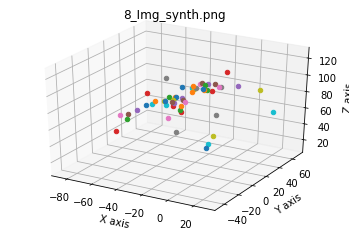

In [11]:
# %matplotlib qt
# to open plot externally and use it interactively
show_entry = 32


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

display_points_3D = out_df.loc[show_entry]["key_points_3D"]

for i,xyz in enumerate(display_points_3D):
    if out_df.loc[show_entry]["visibility"][i] == 1:
        ax.scatter(xyz[0], xyz[1], xyz[2], marker='o')
"""    
# also plot the camera location
ax.scatter(out_df.loc[show_entry]["cam_trans"][0], 
           out_df.loc[show_entry]["cam_trans"][1], 
           out_df.loc[show_entry]["cam_trans"][2], marker='x')
"""

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# use custom function to ensure equal axis proportions
set_axes_equal(ax)

# opens external plot
plt.title(out_df.loc[show_entry]["file_name"])
plt.show()

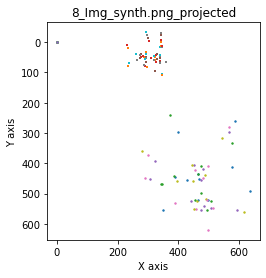

In [12]:
%matplotlib inline
# file_name	cam_rot	cam_trans	cam_intrinsics	bounding_box	key_points_3D	key_points_2D	visibility
R = np.array(out_df.loc[show_entry]["cam_rot"])
T = np.reshape(np.array(out_df.loc[show_entry]["cam_trans"]),(3,1))
C = np.array(out_df.loc[show_entry]["cam_intrinsics"])

#plt.plot(X_2d[0, :], X_2d[1, :], '.')  # plot the locations of the 3D keypoints in 2D as viewed from the camera
#plt.show()

fig = plt.figure()
ax = fig.add_subplot()

for i, x in enumerate(display_points_3D):
    X = np.reshape(np.array(out_df.loc[show_entry]["key_points_3D"][i]),(3,-1))

    # given the above data, it should be possible to project the 3D points into the corresponding image so they land in the correct position on the image 
    P = C @ np.hstack([R, T])  # projection matrix
    X_hom = np.vstack([X, np.ones(X.shape[1])])  # 3D points in homogenous coordinates

    X_hom = P @ X_hom  # project the 3D points
    X_2d = X_hom[:2, :] / X_hom[2, :]  # convert them back to 2D pixel space
    
    gt_x_2d = out_df.loc[show_entry]["key_points_2D"][i][0]
    gt_y_2d = out_df.loc[show_entry]["key_points_2D"][i][1]
    
    ax.scatter(gt_x_2d, gt_y_2d, marker='o', s=2)
    ax.scatter(X_2d[0], X_2d[1], marker='+', s=2)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

#ax.set_xlim([0,640])
#ax.set_ylim([0,640])
ax.set_aspect('equal')

ax.invert_yaxis()

# opens external plot
plt.title(out_df.loc[show_entry]["file_name"] + "_projected")
plt.show()